# Model Selection and Regularization

Methods for selecting the best subset of predictors in linear regression.

## Contents
1. Best Subset Selection
2. Model Selection Criteria (RSS, R², Adjusted R², Cp, BIC)
3. Forward and Backward Stepwise Selection
4. Validation Set Approach
5. K-Fold Cross-Validation for Model Selection

## Setup and Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load Hitters Dataset

Baseball players' salaries and performance statistics.

In [2]:
# Load Hitters dataset
url = "https://raw.githubusercontent.com/selva86/datasets/master/Hitters.csv"
Hitters = pd.read_csv(url)

print(f"Dataset shape: {Hitters.shape}")
print(f"\nColumn names:")
print(Hitters.columns.tolist())
print(f"\nFirst few rows:")
Hitters.head()

Dataset shape: (322, 20)

Column names:
['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division', 'PutOuts', 'Assists', 'Errors', 'Salary', 'NewLeague']

First few rows:


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [3]:
# Check for missing values
print("Missing values per column:")
print(Hitters.isnull().sum())
print(f"\nTotal missing values in Salary: {Hitters['Salary'].isnull().sum()}")

Missing values per column:
AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

Total missing values in Salary: 59


In [4]:
# Remove rows with missing Salary
Hitters = Hitters.dropna()

print(f"Dataset shape after removing NAs: {Hitters.shape}")
print(f"Total missing values: {Hitters.isnull().sum().sum()}")

Dataset shape after removing NAs: (263, 20)
Total missing values: 0


In [5]:
# Data summary
print("Summary statistics:")
Hitters.describe()

Summary statistics:


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000
mean,403.642586,107.828897,11.619772,54.745247,51.486692,41.114068,7.311787,2657.543726,722.186312,69.239544,361.220532,330.418251,260.266160,290.711027,118.760456,8.593156,535.925882
std,147.307209,45.125326,8.757108,25.539816,25.882714,21.718056,4.793616,2286.582929,648.199644,82.197581,331.198571,323.367668,264.055868,279.934575,145.080577,6.606574,451.118681
min,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.000000,4.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,67.500000
25%,282.500000,71.500000,5.000000,33.500000,30.000000,23.000000,4.000000,842.500000,212.000000,15.000000,105.500000,95.000000,71.000000,113.500000,8.000000,3.000000,190.000000
50%,413.000000,103.000000,9.000000,52.000000,47.000000,37.000000,6.000000,1931.000000,516.000000,40.000000,250.000000,230.000000,174.000000,224.000000,45.000000,7.000000,425.000000
75%,526.000000,141.500000,18.000000,73.000000,71.000000,57.000000,10.000000,3890.500000,1054.000000,92.500000,497.500000,424.500000,328.500000,322.500000,192.000000,13.000000,750.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.000000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1377.000000,492.000000,32.000000,2460.000000


## 1. Best Subset Selection

Try all possible combinations of predictors and select the best model for each size.

In [6]:
# Prepare data
# Convert categorical variables to dummy variables
X = pd.get_dummies(Hitters.drop('Salary', axis=1), drop_first=True)
y = Hitters['Salary']

print(f"Number of predictors: {X.shape[1]}")
print(f"Predictor names: {X.columns.tolist()}")

Number of predictors: 19
Predictor names: ['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W', 'NewLeague_N']


In [7]:
def best_subset_selection(X, y, max_features=None):
    """
    Perform best subset selection.
    
    For each model size k, find the best k-variable model.
    """
    if max_features is None:
        max_features = X.shape[1]
    
    n = len(y)
    results = []
    
    for k in range(1, max_features + 1):
        print(f"\rEvaluating models with {k} predictors...", end='')
        
        best_rss = np.inf
        best_features = None
        best_r2 = -np.inf
        
        # Try all combinations of k features
        for features in combinations(X.columns, k):
            X_subset = X[list(features)]
            model = LinearRegression()
            model.fit(X_subset, y)
            y_pred = model.predict(X_subset)
            
            rss = np.sum((y - y_pred) ** 2)
            r2 = r2_score(y, y_pred)
            
            if rss < best_rss:
                best_rss = rss
                best_features = features
                best_r2 = r2
                best_model = model
        
        # Calculate other metrics
        p = k
        adj_r2 = 1 - (1 - best_r2) * (n - 1) / (n - p - 1)
        
        # Cp (Mallows' Cp)
        mse_full = best_rss / n  # Using current model's MSE as estimate
        cp = (best_rss / mse_full) - n + 2 * p
        
        # BIC
        bic = n * np.log(best_rss / n) + p * np.log(n)
        
        results.append({
            'n_features': k,
            'features': best_features,
            'rss': best_rss,
            'r2': best_r2,
            'adj_r2': adj_r2,
            'cp': cp,
            'bic': bic,
            'model': best_model
        })
    
    print("\nDone!")
    return pd.DataFrame(results)

# Note: For large datasets, this is computationally expensive!
# We'll limit to 8 features for demonstration
print("Running best subset selection (limited to 8 features for speed)...")
best_subset_results = best_subset_selection(X, y, max_features=8)

Running best subset selection (limited to 8 features for speed)...
Evaluating models with 8 predictors...
Done!


In [8]:
# Display results
print("\n" + "="*80)
print("BEST SUBSET SELECTION RESULTS")
print("="*80)
display_cols = ['n_features', 'rss', 'r2', 'adj_r2', 'cp', 'bic']
print(best_subset_results[display_cols].round(4))
print("="*80)


BEST SUBSET SELECTION RESULTS
   n_features           rss      r2  adj_r2    cp        bic
0           1  3.617968e+07  0.3215  0.3189   2.0  3117.3498
1           2  3.064656e+07  0.4252  0.4208   4.0  3079.2699
2           3  2.924930e+07  0.4514  0.4451   6.0  3072.5692
3           4  2.797085e+07  0.4754  0.4673   8.0  3066.3872
4           5  2.714990e+07  0.4908  0.4809  10.0  3064.1247
5           6  2.619490e+07  0.5087  0.4972  12.0  3060.2793
6           7  2.590655e+07  0.5141  0.5008  14.0  3062.9402
7           8  2.513693e+07  0.5286  0.5137  16.0  3060.5809


## 2. Model Selection Criteria

Plot different criteria to choose optimal model size.

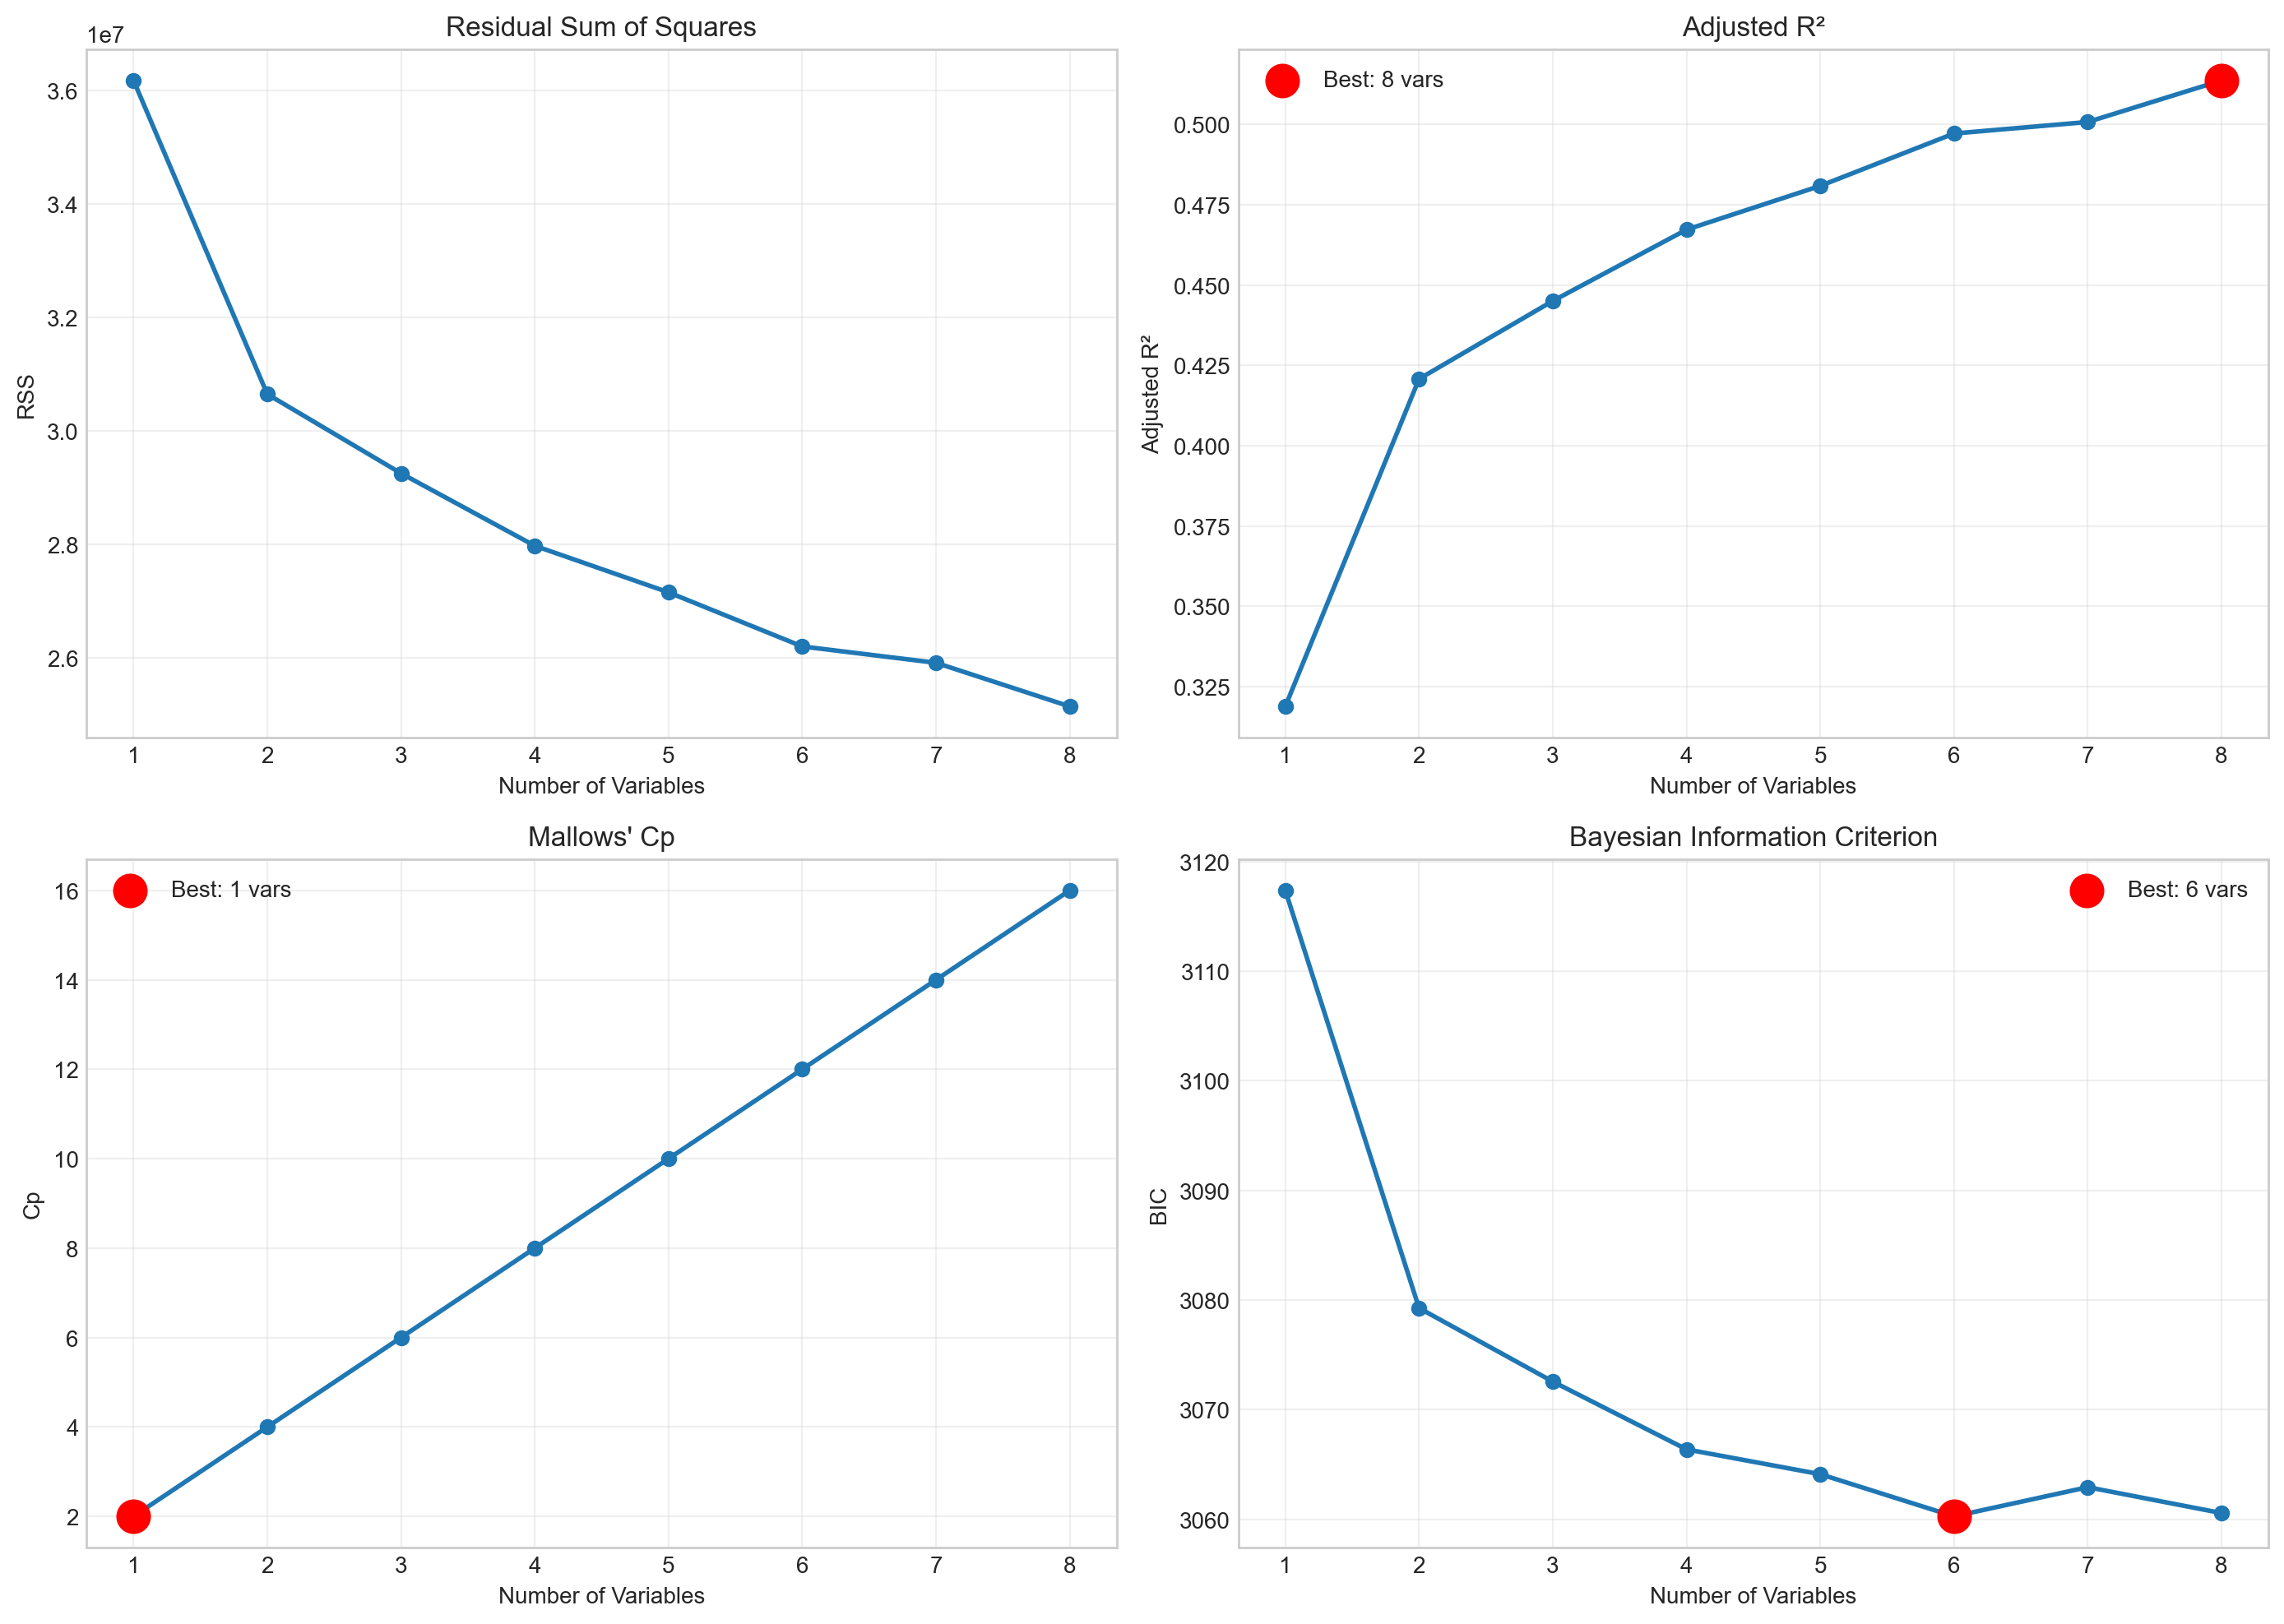


Best model by Adjusted R²: 8 variables
Best model by Cp: 1 variables
Best model by BIC: 6 variables


In [9]:
# Plot selection criteria
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RSS
axes[0, 0].plot(best_subset_results['n_features'], best_subset_results['rss'], 
                marker='o', linewidth=2, markersize=6)
axes[0, 0].set_xlabel('Number of Variables')
axes[0, 0].set_ylabel('RSS')
axes[0, 0].set_title('Residual Sum of Squares')
axes[0, 0].grid(True, alpha=0.3)

# Adjusted R²
best_idx_adjr2 = best_subset_results['adj_r2'].idxmax()
axes[0, 1].plot(best_subset_results['n_features'], best_subset_results['adj_r2'], 
                marker='o', linewidth=2, markersize=6)
axes[0, 1].scatter(best_subset_results.loc[best_idx_adjr2, 'n_features'], 
                   best_subset_results.loc[best_idx_adjr2, 'adj_r2'], 
                   color='red', s=200, zorder=5, label=f"Best: {best_subset_results.loc[best_idx_adjr2, 'n_features']} vars")
axes[0, 1].set_xlabel('Number of Variables')
axes[0, 1].set_ylabel('Adjusted R²')
axes[0, 1].set_title('Adjusted R²')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Cp
best_idx_cp = best_subset_results['cp'].idxmin()
axes[1, 0].plot(best_subset_results['n_features'], best_subset_results['cp'], 
                marker='o', linewidth=2, markersize=6)
axes[1, 0].scatter(best_subset_results.loc[best_idx_cp, 'n_features'], 
                   best_subset_results.loc[best_idx_cp, 'cp'], 
                   color='red', s=200, zorder=5, label=f"Best: {best_subset_results.loc[best_idx_cp, 'n_features']} vars")
axes[1, 0].set_xlabel('Number of Variables')
axes[1, 0].set_ylabel('Cp')
axes[1, 0].set_title("Mallows' Cp")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# BIC
best_idx_bic = best_subset_results['bic'].idxmin()
axes[1, 1].plot(best_subset_results['n_features'], best_subset_results['bic'], 
                marker='o', linewidth=2, markersize=6)
axes[1, 1].scatter(best_subset_results.loc[best_idx_bic, 'n_features'], 
                   best_subset_results.loc[best_idx_bic, 'bic'], 
                   color='red', s=200, zorder=5, label=f"Best: {best_subset_results.loc[best_idx_bic, 'n_features']} vars")
axes[1, 1].set_xlabel('Number of Variables')
axes[1, 1].set_ylabel('BIC')
axes[1, 1].set_title('Bayesian Information Criterion')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest model by Adjusted R²: {best_subset_results.loc[best_idx_adjr2, 'n_features']} variables")
print(f"Best model by Cp: {best_subset_results.loc[best_idx_cp, 'n_features']} variables")
print(f"Best model by BIC: {best_subset_results.loc[best_idx_bic, 'n_features']} variables")

## 3. Forward and Backward Stepwise Selection

More efficient alternatives to best subset selection.

In [10]:
def forward_stepwise_selection(X, y, max_features=None):
    """
    Forward stepwise selection: Start with no variables, add one at a time.
    """
    if max_features is None:
        max_features = X.shape[1]
    
    remaining = set(X.columns)
    selected = []
    results = []
    
    for k in range(1, max_features + 1):
        print(f"\rForward step {k}...", end='')
        
        best_rss = np.inf
        best_feature = None
        
        for feature in remaining:
            features = selected + [feature]
            X_subset = X[features]
            model = LinearRegression()
            model.fit(X_subset, y)
            y_pred = model.predict(X_subset)
            rss = np.sum((y - y_pred) ** 2)
            
            if rss < best_rss:
                best_rss = rss
                best_feature = feature
                best_model = model
        
        selected.append(best_feature)
        remaining.remove(best_feature)
        
        # Calculate metrics
        X_subset = X[selected]
        y_pred = best_model.predict(X_subset)
        r2 = r2_score(y, y_pred)
        
        results.append({
            'n_features': k,
            'features': tuple(selected),
            'rss': best_rss,
            'r2': r2
        })
    
    print(" Done!")
    return pd.DataFrame(results)

def backward_stepwise_selection(X, y):
    """
    Backward stepwise selection: Start with all variables, remove one at a time.
    """
    selected = list(X.columns)
    results = []
    
    # Full model
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    rss = np.sum((y - y_pred) ** 2)
    r2 = r2_score(y, y_pred)
    
    results.append({
        'n_features': len(selected),
        'features': tuple(selected),
        'rss': rss,
        'r2': r2
    })
    
    while len(selected) > 1:
        print(f"\rBackward step (removing from {len(selected)} vars)...", end='')
        
        best_rss = np.inf
        worst_feature = None
        
        for feature in selected:
            features = [f for f in selected if f != feature]
            X_subset = X[features]
            model = LinearRegression()
            model.fit(X_subset, y)
            y_pred = model.predict(X_subset)
            rss = np.sum((y - y_pred) ** 2)
            
            if rss < best_rss:
                best_rss = rss
                worst_feature = feature
                best_model = model
        
        selected.remove(worst_feature)
        
        # Calculate metrics
        X_subset = X[selected]
        y_pred = best_model.predict(X_subset)
        r2 = r2_score(y, y_pred)
        
        results.append({
            'n_features': len(selected),
            'features': tuple(selected),
            'rss': best_rss,
            'r2': r2
        })
    
    print(" Done!")
    return pd.DataFrame(results).sort_values('n_features').reset_index(drop=True)

In [12]:
# Run forward and backward selection
print("Running forward stepwise selection...")
forward_results = forward_stepwise_selection(X, y, max_features=8)

print("\nRunning backward stepwise selection...")
backward_results = backward_stepwise_selection(X, y)
backward_results = backward_results[backward_results['n_features'] <= 8]

Running forward stepwise selection...
Forward step 8... Done!

Running backward stepwise selection...
Backward step (removing from 2 vars)... Done!


In [13]:
# Compare methods
print("\n" + "="*80)
print("COMPARISON: BEST SUBSET vs FORWARD vs BACKWARD")
print("="*80)

comparison = pd.DataFrame({
    'n_features': best_subset_results['n_features'],
    'Best_Subset_R2': best_subset_results['r2'],
    'Forward_R2': forward_results['r2'],
    'Backward_R2': backward_results['r2']
})

print(comparison.round(4))
print("="*80)


COMPARISON: BEST SUBSET vs FORWARD vs BACKWARD
   n_features  Best_Subset_R2  Forward_R2  Backward_R2
0           1          0.3215      0.3215       0.3166
1           2          0.4252      0.4252       0.4148
2           3          0.4514      0.4514       0.4485
3           4          0.4754      0.4754       0.4664
4           5          0.4908      0.4908       0.4841
5           6          0.5087      0.5087       0.4997
6           7          0.5141      0.5132       0.5136
7           8          0.5286      0.5281       0.5281


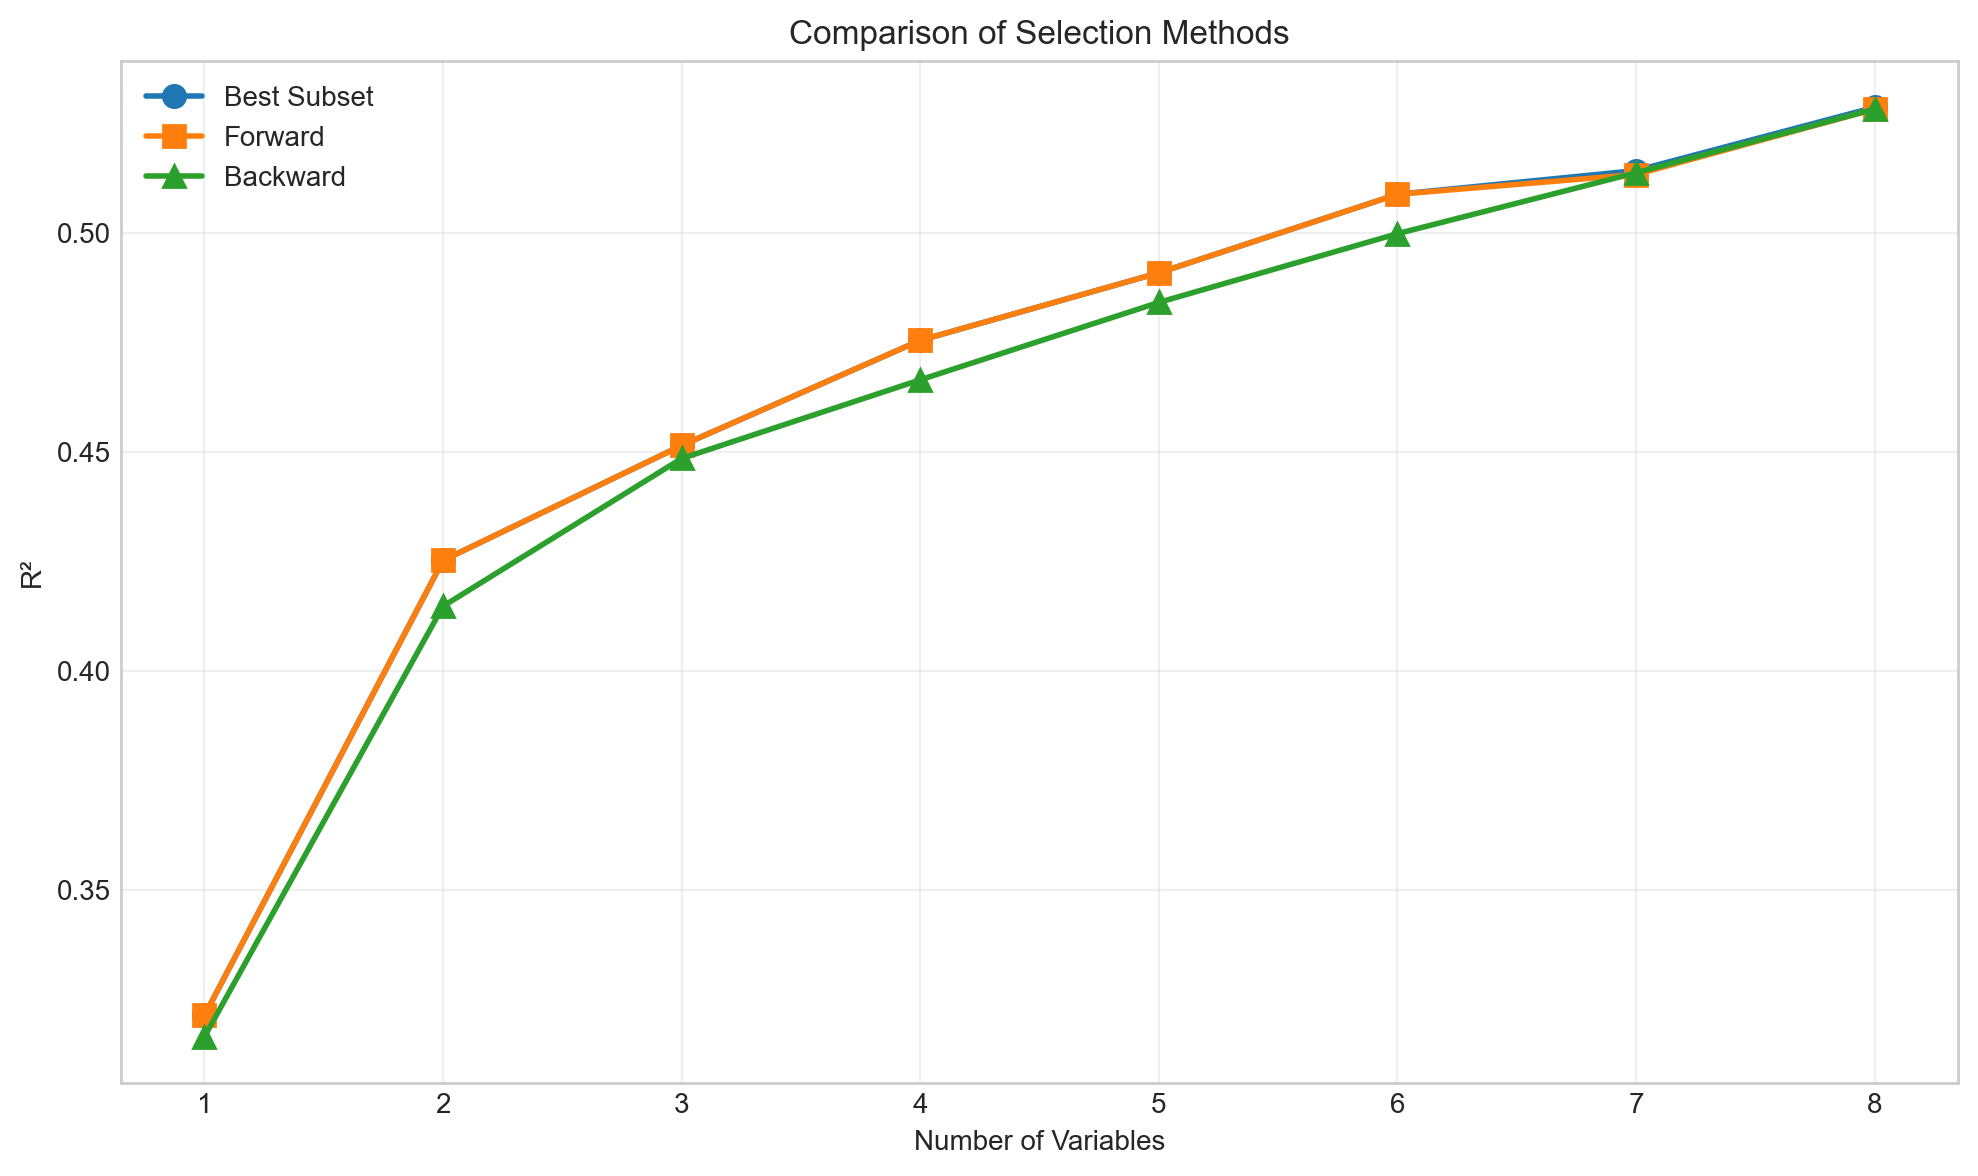

In [14]:
# Visualize comparison
plt.figure(figsize=(10, 6))
plt.plot(best_subset_results['n_features'], best_subset_results['r2'], 
         marker='o', label='Best Subset', linewidth=2, markersize=8)
plt.plot(forward_results['n_features'], forward_results['r2'], 
         marker='s', label='Forward', linewidth=2, markersize=8)
plt.plot(backward_results['n_features'], backward_results['r2'], 
         marker='^', label='Backward', linewidth=2, markersize=8)
plt.xlabel('Number of Variables')
plt.ylabel('R²')
plt.title('Comparison of Selection Methods')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Validation Set Approach

In [15]:
# Split data
np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 131
Test set size: 132


In [16]:
# Forward selection on training set
forward_train_results = forward_stepwise_selection(X_train, y_train, max_features=X.shape[1])

# Evaluate on test set
val_errors = []

for idx, row in forward_train_results.iterrows():
    features = list(row['features'])
    X_test_subset = X_test[features]
    
    # Refit model on training data with these features
    model = LinearRegression()
    model.fit(X_train[features], y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test_subset)
    mse = mean_squared_error(y_test, y_pred)
    val_errors.append(mse)

forward_train_results['test_mse'] = val_errors

Forward step 19... Done!


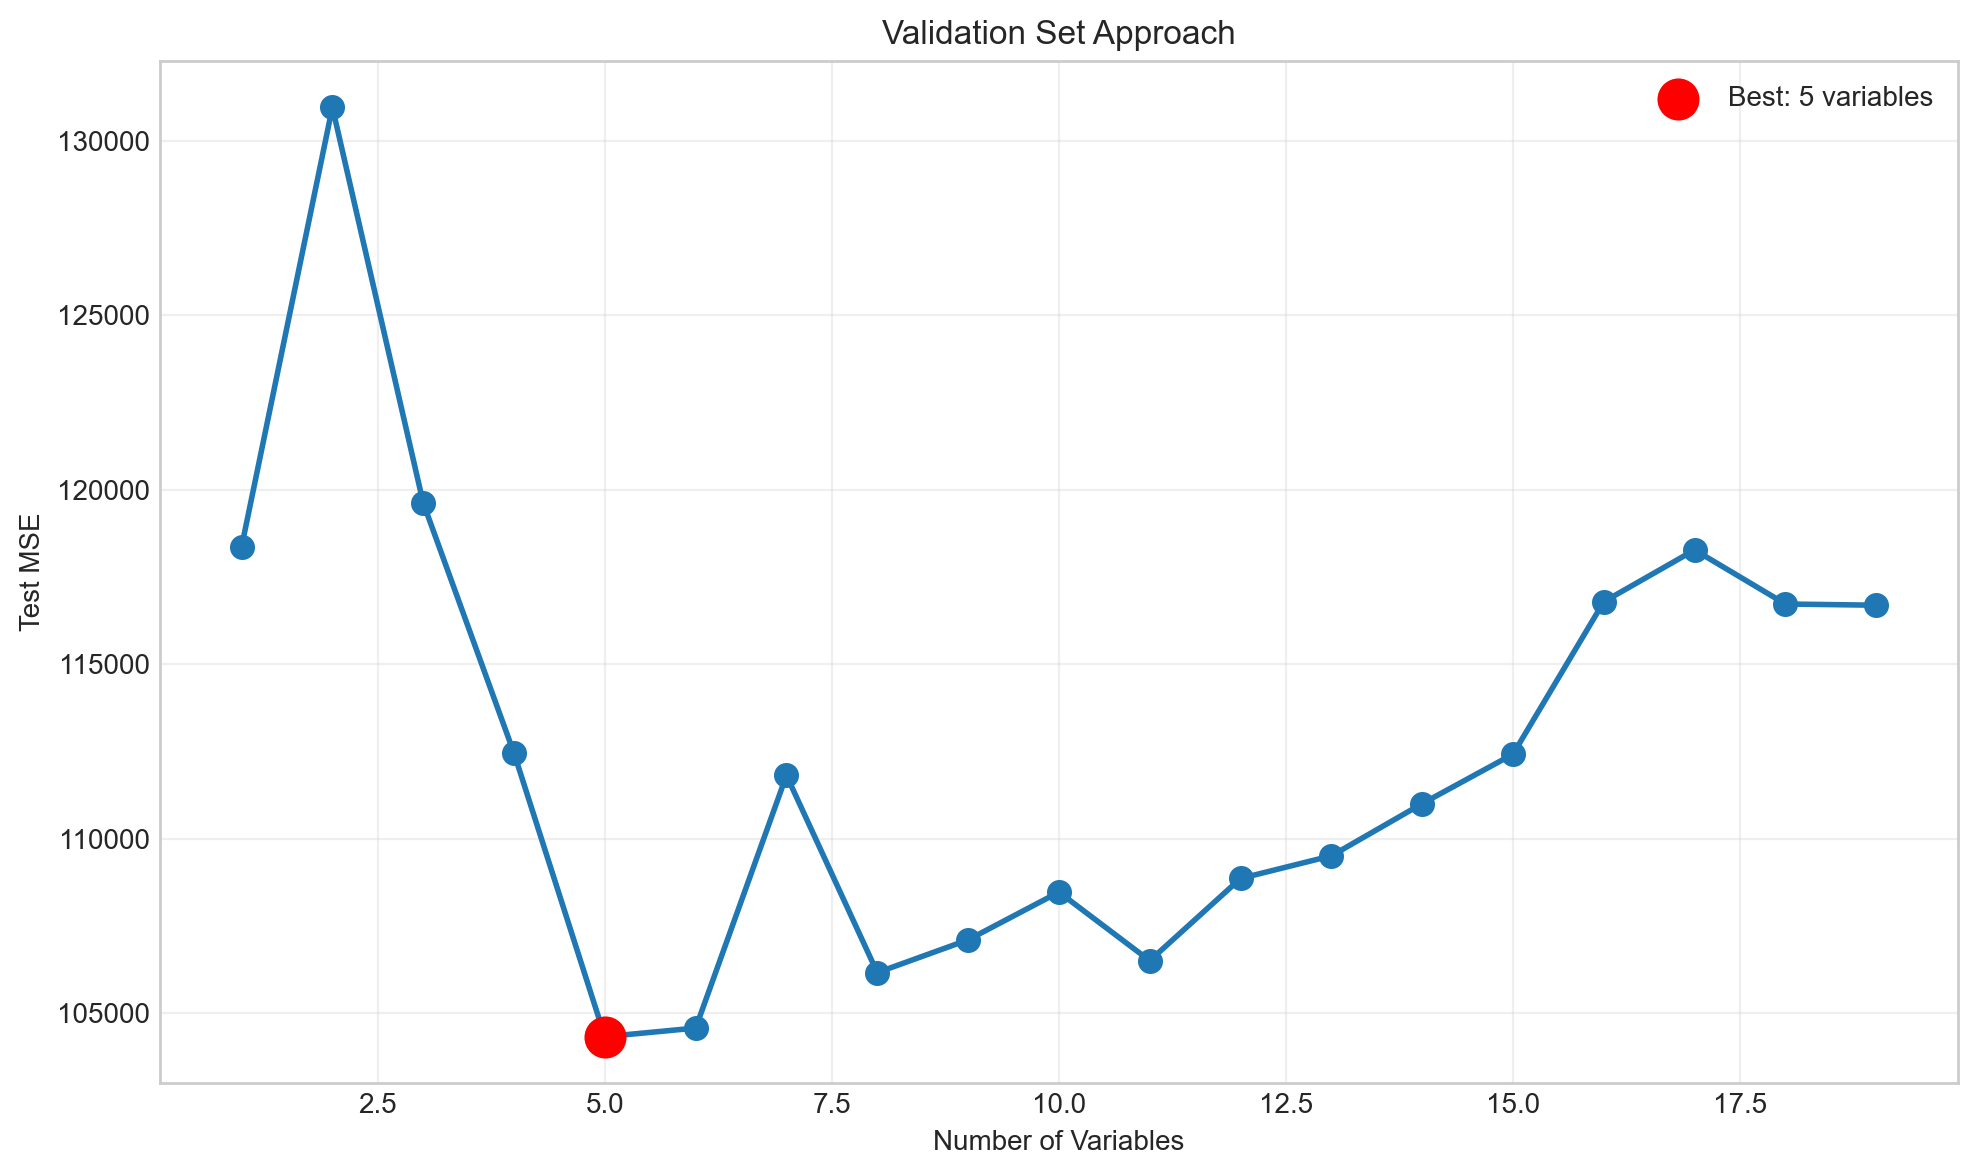


Best model has 5 variables
Test MSE: 104319.5326

Features: ('CRBI', 'PutOuts', 'Walks', 'Division_W', 'Hits')


In [17]:
# Plot validation errors
plt.figure(figsize=(10, 6))
plt.plot(forward_train_results['n_features'], forward_train_results['test_mse'], 
         marker='o', linewidth=2, markersize=8)

best_idx = forward_train_results['test_mse'].idxmin()
plt.scatter(forward_train_results.loc[best_idx, 'n_features'], 
           forward_train_results.loc[best_idx, 'test_mse'], 
           color='red', s=200, zorder=5, 
           label=f"Best: {forward_train_results.loc[best_idx, 'n_features']} variables")

plt.xlabel('Number of Variables')
plt.ylabel('Test MSE')
plt.title('Validation Set Approach')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest model has {forward_train_results.loc[best_idx, 'n_features']} variables")
print(f"Test MSE: {forward_train_results.loc[best_idx, 'test_mse']:.4f}")
print(f"\nFeatures: {forward_train_results.loc[best_idx, 'features']}")

## 5. K-Fold Cross-Validation for Model Selection

In [18]:
# K-Fold Cross-Validation
k = 10
np.random.seed(1)
kf = KFold(n_splits=k, shuffle=True, random_state=1)

# Matrix to store CV errors
cv_errors = np.zeros((k, X.shape[1]))

for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X)):
    print(f"\rProcessing fold {fold_idx + 1}/{k}...", end='')
    
    X_train_fold = X.iloc[train_idx]
    y_train_fold = y.iloc[train_idx]
    X_test_fold = X.iloc[test_idx]
    y_test_fold = y.iloc[test_idx]
    
    # Forward selection on this fold
    fold_results = forward_stepwise_selection(X_train_fold, y_train_fold, max_features=X.shape[1])
    
    # Evaluate each model size
    for idx, row in fold_results.iterrows():
        features = list(row['features'])
        
        # Refit and predict
        model = LinearRegression()
        model.fit(X_train_fold[features], y_train_fold)
        y_pred = model.predict(X_test_fold[features])
        mse = mean_squared_error(y_test_fold, y_pred)
        
        cv_errors[fold_idx, row['n_features'] - 1] = mse

print(" Done!")

# Calculate mean CV error for each model size
mean_cv_errors = cv_errors.mean(axis=0)
std_cv_errors = cv_errors.std(axis=0)

Forward step 19... Done!
Forward step 19... Done!
Forward step 19... Done!
Forward step 19... Done!
Forward step 19... Done!
Forward step 19... Done!
Forward step 19... Done!
Forward step 19... Done!
Forward step 19... Done!
Forward step 19... Done!
 Done!


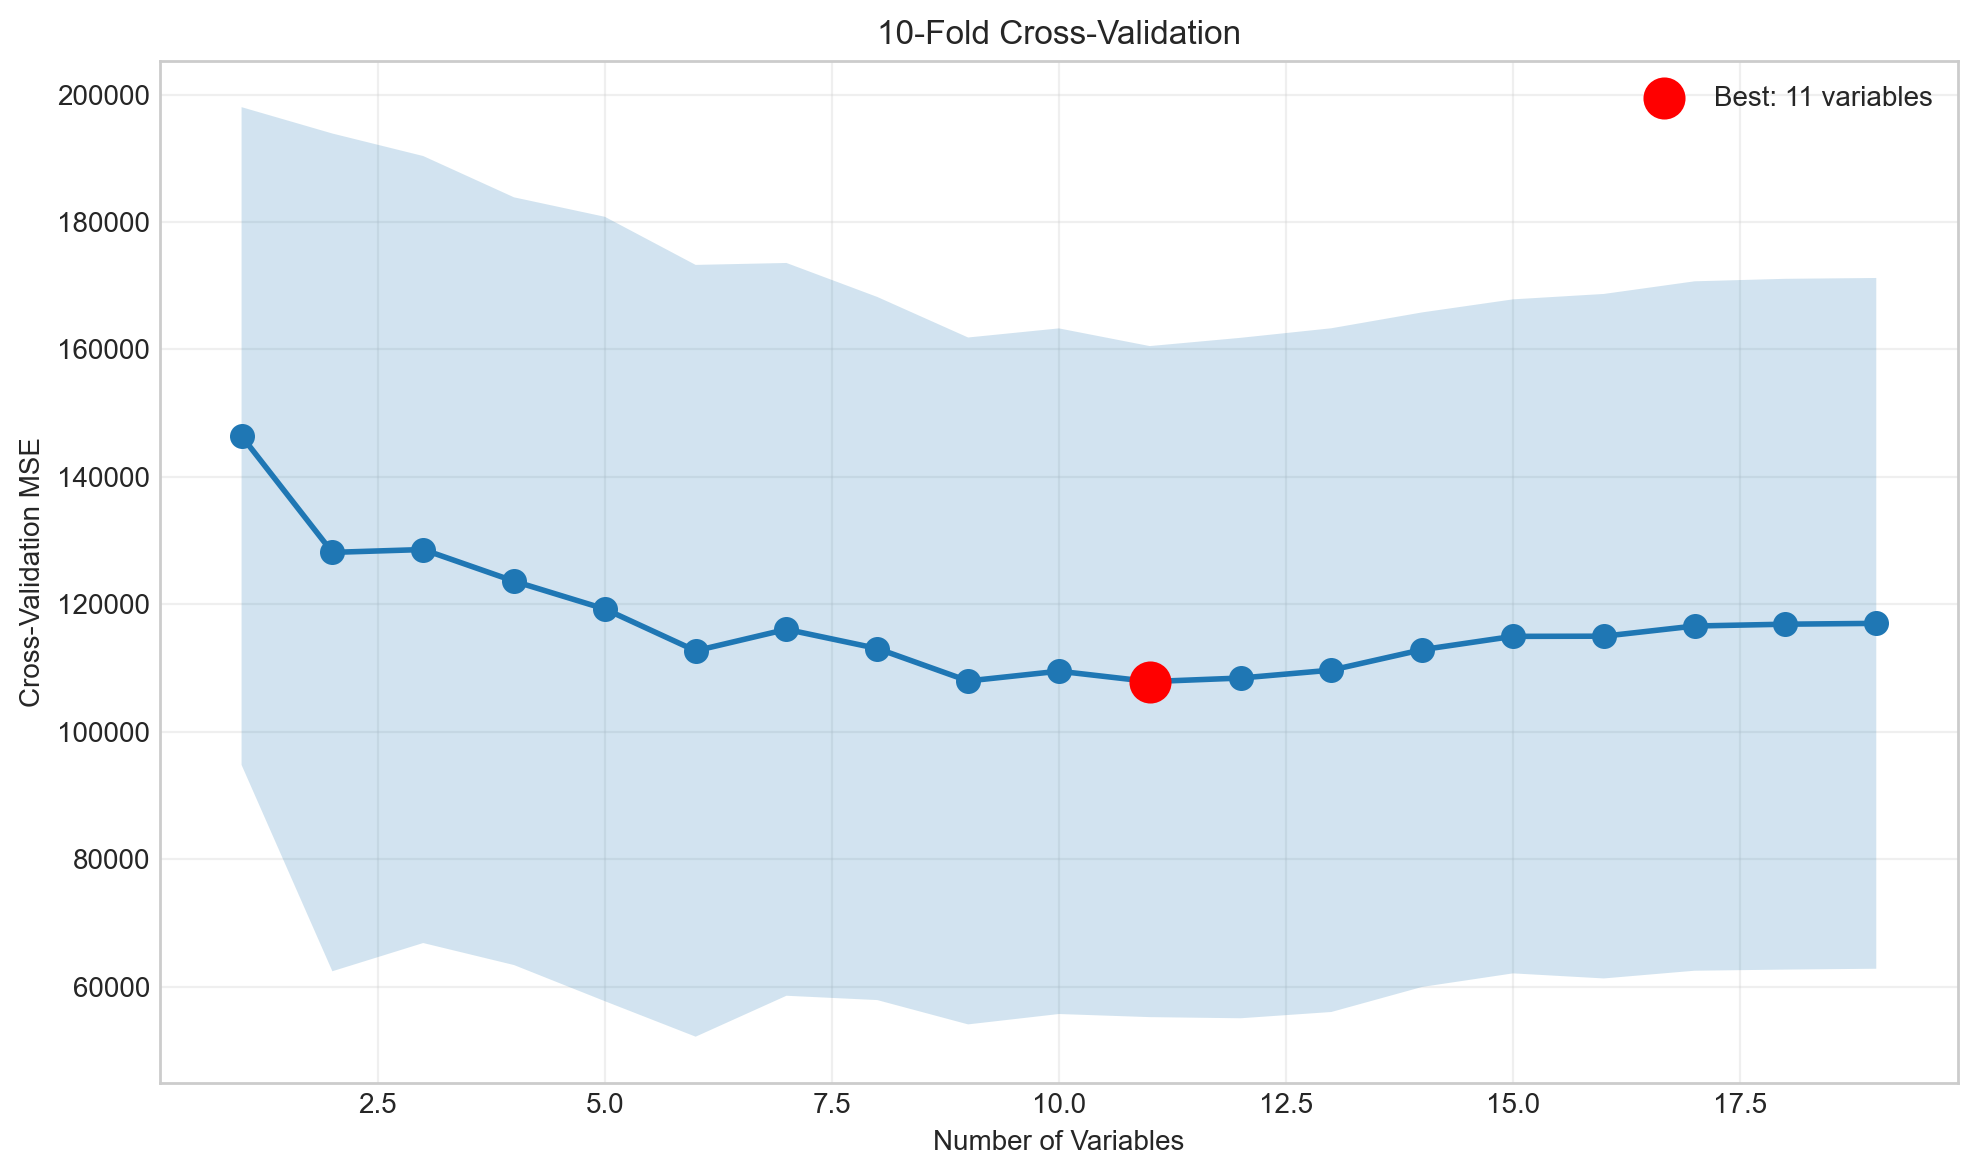


Best model by 10-Fold CV: 11 variables
CV MSE: 107888.9671 ± 52643.4463


In [19]:
# Plot CV errors
plt.figure(figsize=(10, 6))
plt.plot(range(1, X.shape[1] + 1), mean_cv_errors, marker='o', linewidth=2, markersize=8)
plt.fill_between(range(1, X.shape[1] + 1), 
                 mean_cv_errors - std_cv_errors,
                 mean_cv_errors + std_cv_errors,
                 alpha=0.2)

best_idx_cv = np.argmin(mean_cv_errors)
plt.scatter(best_idx_cv + 1, mean_cv_errors[best_idx_cv], 
           color='red', s=200, zorder=5, label=f"Best: {best_idx_cv + 1} variables")

plt.xlabel('Number of Variables')
plt.ylabel('Cross-Validation MSE')
plt.title(f'{k}-Fold Cross-Validation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nBest model by {k}-Fold CV: {best_idx_cv + 1} variables")
print(f"CV MSE: {mean_cv_errors[best_idx_cv]:.4f} ± {std_cv_errors[best_idx_cv]:.4f}")

In [20]:
# Fit final model on full dataset with optimal number of features
final_results = forward_stepwise_selection(X, y, max_features=X.shape[1])
best_features = list(final_results.iloc[best_idx_cv]['features'])

print(f"\nFinal model with {len(best_features)} variables:")
print(best_features)

# Fit and display coefficients
final_model = LinearRegression()
final_model.fit(X[best_features], y)

coef_df = pd.DataFrame({
    'Feature': best_features,
    'Coefficient': final_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\nCoefficients:")
print(coef_df)
print(f"\nIntercept: {final_model.intercept_:.4f}")

Forward step 19... Done!

Final model with 11 variables:
['CRBI', 'Hits', 'PutOuts', 'Division_W', 'AtBat', 'Walks', 'CWalks', 'CRuns', 'CAtBat', 'Assists', 'League_N']

Coefficients:
       Feature  Coefficient
3   Division_W  -111.146025
10    League_N    43.111615
1         Hits     6.923699
5        Walks     5.620276
4        AtBat    -2.127748
7        CRuns     1.455331
6       CWalks    -0.822856
0         CRBI     0.785253
2      PutOuts     0.289409
9      Assists     0.268828
8       CAtBat    -0.138991

Intercept: 135.7512


## Summary

This notebook covered:

### **Best Subset Selection**
- Try all possible combinations of predictors
- Computationally expensive: 2^p models for p predictors
- Guarantees finding the best model for each size

### **Forward Stepwise Selection**
- Start with no variables, add one at a time
- Greedy algorithm: may not find global optimum
- Much faster: only p(p+1)/2 models

### **Backward Stepwise Selection**
- Start with all variables, remove one at a time
- Also greedy
- Requires n > p (more observations than predictors)

### **Selection Criteria**
- **RSS**: Always decreases with more variables
- **R²**: Always increases with more variables
- **Adjusted R²**: Penalizes model complexity
- **Cp**: Estimates test error
- **BIC**: Stronger penalty than Cp

### **Cross-Validation**
- Most reliable method for model selection
- Directly estimates test error
- K=5 or K=10 are common choices

### **Key Takeaways:**
- More variables ≠ better model (overfitting!)
- Use CV to select model size
- Forward/backward are good approximations to best subset
- Different criteria may suggest different model sizes